# Segmentation of fluorescence images

In [1]:
import pandas as pd
import numpy as np
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import skimage.feature
import os

import spatial_tools
from spatial_tools.image.object import ImageContainer

# path to "raw" dataset folder
#BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla/"
BASE_PATH = "/Users/david.fischer/phd/datasets/2020_10x_visium/"
dataset_name = "V1_Human_Brain_Section_1"
dataset_folder = os.path.join(
    BASE_PATH, "2020_10XFluoVisium_HumanBrain1_giovanni.palla"
)

# Read data

In [2]:
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
img_id = "V1_Human_Brain_Section_1_image"
img = ImageContainer(
    img=dataset_folder+"/"+f"{dataset_name}_image.tif",
    img_id=img_id,
    lazy=True
)

adding V1_Human_Brain_Section_1_image into object


/Users/david.fischer/opt/miniconda3/lib/python3.7/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Explore raw image and feature values:

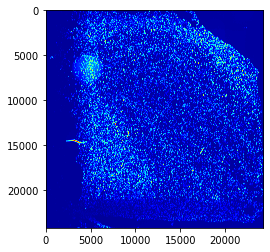

In [4]:
plt.imshow(img.data["V1_Human_Brain_Section_1_image_0"][0], cmap='jet')

(array([5.0444430e+08, 2.8228494e+07, 1.4052832e+07, 7.6950460e+06,
        5.4322910e+06, 4.1703310e+06, 3.3808390e+06, 2.8534460e+06,
        2.5307100e+06, 1.4789311e+07]),
 array([    0. ,  6553.2, 13106.4, 19659.6, 26212.8, 32766. , 39319.2,
        45872.4, 52425.6, 58978.8, 65532. ]),
 <a list of 10 Patch objects>)

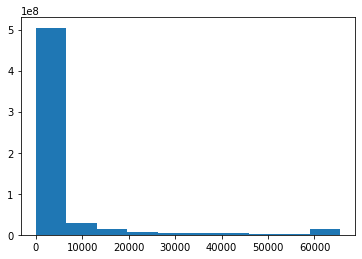

In [5]:
plt.hist(np.asarray(img.data["V1_Human_Brain_Section_1_image_0"][0]).flatten())

# Segmentation method

In [6]:
from spatial_tools.image.segment import segment, segment_crops

## Blob detection

TODO

## Watershed

In [7]:
segment(
    img=img,
    img_id="V1_Human_Brain_Section_1_image_0",
    model_group="watershed",
    model_kwargs={
        "thresh": 50000, 
        "geq": True
    },
    xs=1000,
    ys=1000,
)

adding segmented_watershed into object


In [8]:
img.data

<xarray.Dataset>
Dimensions:                           (channels: 1, x: 24240, y: 24240)
Coordinates:
  * channels                          (channels) int64 1
Dimensions without coordinates: x, y
Data variables:
    V1_Human_Brain_Section_1_image_0  (channels, y, x) uint16 ...
    V1_Human_Brain_Section_1_image_1  (channels, y, x) uint16 ...
    V1_Human_Brain_Section_1_image_2  (channels, y, x) uint16 ...
    V1_Human_Brain_Section_1_image_3  (channels, y, x) uint16 ...
    segmented_watershed               (y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

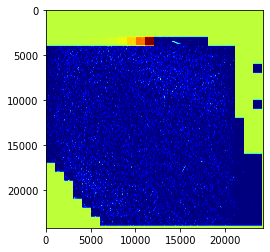

In [9]:
plt.imshow(img.data["segmented_watershed"], cmap='jet')

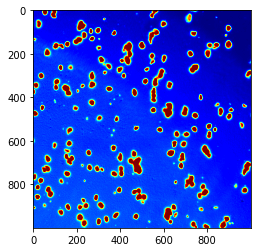

In [10]:
plt.imshow(img.data["V1_Human_Brain_Section_1_image_0"][0][5000:6000, 5000:6000], cmap='jet')

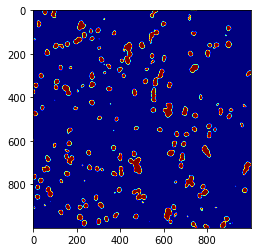

In [11]:
plt.imshow(img.data["segmented_watershed"][5000:6000, 5000:6000], cmap='jet')

Summarize number and size of segments:

(array([20768424.,   974866.,   975153.,        0.,   974921.,        0.,
               0.,        0.,        0.,   972165.]),
 array([1.00000000e+00, 1.27038401e+08, 2.54076801e+08, 3.81115201e+08,
        5.08153601e+08, 6.35192000e+08, 7.62230400e+08, 8.89268800e+08,
        1.01630720e+09, 1.14334560e+09, 1.27038400e+09]),
 <a list of 10 Patch objects>)

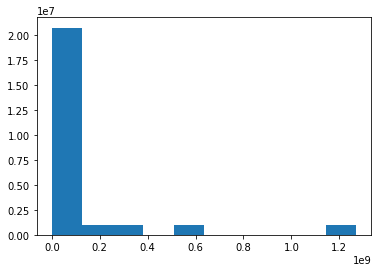

In [12]:
plt.hist(np.asarray(img.data["segmented_watershed"])[img.data["segmented_watershed"] > 0].flatten())

In [13]:
np.max(img.data["segmented_watershed"])

<xarray.DataArray 'segmented_watershed' ()>
array(1.270384e+09)

# Segmentation format

Above, we showed how the entire image can be segmented through integration across crop-wise segementations. Additionally, one can also segment a specific crop:

In [14]:
crop = ImageContainer(
    img=img.crop(x=5500, y=5500, xs=500, ys=500).T,
    img_id="crop",
)

adding crop into object


In [15]:
crop.data

<xarray.Dataset>
Dimensions:  (channels: 5, x: 500, y: 500)
Dimensions without coordinates: channels, x, y
Data variables:
    crop     (channels, y, x) float64 1.182e+04 1.241e+04 ... -1.754e+09

In [16]:
segment(
    img=crop,
    img_id="crop",
    model_group="watershed",
    model_kwargs={
        "thresh": 50000, 
        "geq": False
    },
)

adding segmented_watershed into object


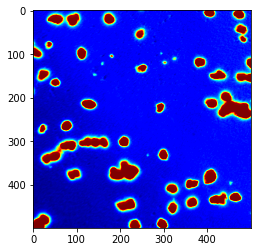

In [17]:
plt.imshow(crop.data["crop"][0], cmap='jet')

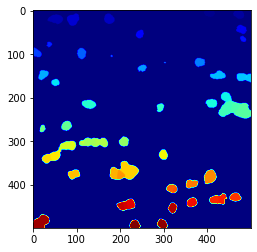

In [18]:
plt.imshow(crop.data["segmented_watershed"], cmap='jet')

# Extract features on segments

## Extract crops centred on segments

In [19]:
crop.data["segmented_watershed"]

<xarray.DataArray 'segmented_watershed' (y: 500, x: 500)>
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [66, 66, 66, ...,  0,  0,  0],
       [66, 66, 66, ...,  0,  0,  0],
       [66, 66, 66, ...,  0,  0,  0]], dtype=int32)
Dimensions without coordinates: y, x

In [20]:
cell_width = 15
cell_height = 15
cell_crops = segment_crops(
    img=crop,
    segmented_img_id="segmented_watershed",
    img_id="crop",
    xs=cell_width,
    ys=cell_height,
)

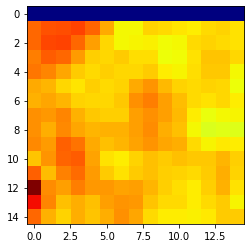

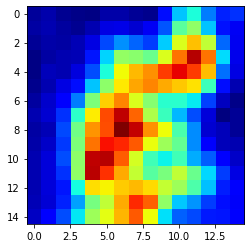

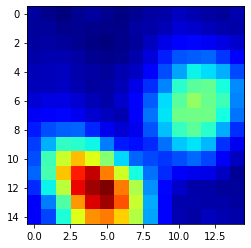

In [21]:
for i in range(3):
    plt.imshow(cell_crops[i][1], cmap='jet')
    plt.show()

## Extract features on crops

In [34]:
from spatial_tools.image.tools import get_grey_texture_features

TODO